# Agrupando estaciones por actividad: Definiendo perfiles de las estaciones en Ecobici

In [2]:
%%HTML
<b>Sección anterior: </b>
<a href="http://nbviewer.jupyter.org/github/jaircastruita/visualizations/blob/master/Consensus_clustering_raw_Matrix.ipynb">
Agrupación alternativa para el perfil de las estaciones utilizando consensus clustering (Datos no normalizados).</a>
<br/>
<b>Siguiente sección: </b>
<a href="http://nbviewer.jupyter.org/github/jaircastruita/visualizations/blob/master/SARIMA_011_011_forecast.ipynb">
Sarima(0,1,1)(0,1,1), un modelo de tendencia que varía con el tiempo.</a>

A lo largo del los horarios de servicio las estaciones de Ecobici

Desde que se inauguró el sistema de bike sharing Ecobici en la ciudad de México ocurrieron 2 procesos de expansión al programa en sus primeros 4 años, esto quiere decir que se agregaron nuevas estaciones de bicicletas en nuevas delegaciones mientras el sistema estaba en uso.

Hipótesis: Si se realiza un proceso de clustering sobre el comportamiento promedio de las estaciones tomando en cuenta las variables que juegan un factor en el periodo comprendido en cada fase podemos apreciar cambios en el comportamiento de estaciones previas tras la inclusión de nuevas estaciones al programa.

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
import folium
import itertools
import numpy as np

import vincent
vincent.core.initialize_notebook()
import json
from vincent import AxisProperties, PropertySet, ValueRef

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 10

# Mixture models

Existen diferentes procesos de agrupación para realizar clustering, todos con pros y contras, los cuales hacen necesario conocer el problema y tener una idea sobre lo que se quiere lograr aplicando dichas técnicas.

Mixture models es un modelo extendido del bien conocido método de k-means pero con suposiciones diferentes, como la suposición de que dichas obsevaciones son miembros de una distribución normal multidimensional, cada una con una media y matriz de covarianza distintas (Kevin P. Murphy - Machine Learning, a probabilistic perspective).

Un contra con esta herramienta suele ser el determinar el número de clusters a priori que deben ser utilizados. Muchas veces, debido a la elevada dimensionalidad, esta se vuelve una tarea difícil de realizar utilizando la intuición por lo que es necesario recurrir a herramientas que midan la separación entre grupos de clusters generados bajo una métrica de distancia seleccionada. En esta situación se utilizará una variación de 1 a 6 clusters, la métrica seleccionada será distancia Euclidiana. Es común que en medidas que involucren conteos sobre el tiempo otro tipo de medida más adecuado sea utilizado, inclusive hasta puede tomarse que una métrica Euclideana sea algo ingenua para establecer distancias pero bajo el argumento de que esto solo representa una herramienta de visualización en los datos con la finalidad de entender mejor el comportamiento de las estaciones se continuará con el modelo simplificado descrito anteriormente.

In [2]:
def best_GMM(X):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
                
    plot_bic(bic,cv_types,n_components_range,best_gmm)
    return best_gmm

# Evalación de clustering: Bayesian information criteria

Como se ha mencionado anteriormente, una técnica bien conocida para utilizar como apoyo cuando la intuición no es suficiente en la decisión del número de clusters necesarios a utilizar es evaluando la pertenencia de los clusters con BIC. La siguiente función muestra los resultados de los índices BIC que se obtienen con los diferentes números de cluster utilizados, también de variar la tendencia en la matriz de covarianza que se utilizó con dicha técnica. El índice BIC indica una mejor separación entre los grupos generados entre mayor valor del índice se obtenga.

In [3]:
def plot_bic(bic,cv_types,n_components_range,best_gmm):
    bic = np.array(bic)
    color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)

# Limpieza de los registros

En este proceso se presentan los perfiles de las estaciones de Ecobici realizado sobre los conteos en las bicicletas que llegan a las estaciones. Lo primero es realizar limpieza de los datos con la finalidad de eliminar información que pueda generar ruido en el estudio llevando a obtener interpretaciones espurias del mismo. Para llevar a cabo esta limpieza se realizó lo siguente:

- Debido al variado comportamiento que ocurre en el sistema fines de semana y días entre semana, el estado del arte recomienda realizar una división sobre estos días, es por eso que se agrega una etiqueta sobre cada uno de estos días, separando días entre semana de días en fin de semana trabajando solo con días entre semana debido a que son los que reflejan la cultura de actividad más reproducible.
- Se realizó un conteo de actividad del sistema a lo largo de los días. Existen algunos donde el conteo de actividad es inusualmente bajo. Para obtener estos días de manera automática se realizó lo siguiente: Se obtuvo la media móvil (moving average) y la desviación estándar móvil (moving standard deviation) de los conteos en el sistema a lo largo de 20 días anteriores. se removieron todas aquellas fechas cuyos conteos fueran menores al moving average menos dos veces la moving standard deviation.
- Se eliminaron todas aquellas estaciones cuya ID fuese mayor a 275 debido a que en el sistema de Ecobici no existen estaciones con un ID superior a este número hasta principios del año 2015.

# Características

Las características que se tomarán en cuenta por el modelo para realizar la agrupación en las estaciones se obtuvieron de la siguente manera: Durante una cantidad de tiempo $\Delta$ se obtuvo el conteo de el número de bicicletas entrantes y salientes de la estación $e_n$ en la hora $t$, con un valor de $\Delta$ = 1hr debido a que tiene un buen compromiso entre conteos necesarios para alzar un patrón a lo largo del día  y estabilidad para no volver la señal demasiado inestable.

El sistema de Ecobici solo ofrece servicio en los horarios de 06:00 a 00:00 horas, por lo que solo esos horarios fueron contemplados para construir el vector de características, eliminando así 6 horas para cada día.

Para la obtención de un día representativo para cada estación lo siguiente que se realizó fue obtener el valor medio por cada valor $t$ a lo largo del día tanto en las características que corresponden a conteos de entrada como de salida. 

Finalmente obtenemos un vector de características $x_{1in},\dots,x_{18in},x_{1out},\dots,x_{18out}$ por cada estación $e_n$ donde se representa el número de bicicletas entrantes y salientes en esa estación a lo largo del día.

In [4]:
path = r'D:\ownCloud\Documentos posgrado\Posgrado 2do semestre\Seminario investigacion\Experimental Data\Cd Mex\Movilidad\Hist Ecobici\ecobici.csv'
trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)

trips = trips.loc[trips['action'] != 'C  ']

# Find the start date
ind = pd.DatetimeIndex(trips.date_arrived)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

# Count trips by date
by_date = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_arrived', )

by_date.drop([col for col in list(by_date.columns.values) if col > 275], 
        axis=1, inplace=True)

# add a flag indicating weekend
by_date['weekend'] = (by_date.index.dayofweek >= 5)

by_date_weekday = by_date[by_date['weekend'] == False]

mavg_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).mean()
mstd_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).std()

black_list = by_date_weekday.sum(axis=1)[by_date_weekday.sum(axis=1) <= mavg_wd-2*mstd_wd].index

by_date_weekend = by_date[by_date['weekend'] == True]

mavg_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).mean()
mstd_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).std()

black_list = black_list.union(by_date_weekend.sum(axis=1)[by_date_weekend.sum(axis=1) <= mavg_we-2*mstd_we].index)

In [5]:
trips_in = pd.read_csv(path,
                        parse_dates=['date_removed', 'date_arrived'],
                        infer_datetime_format=True,
                        low_memory=False)

trips_in = trips_in.loc[trips_in['action'] != 'C  ']

# Find the start date
ind = pd.DatetimeIndex(trips.date_arrived)
trips_in['date'] = ind.date.astype('datetime64')
trips_in['hour'] = ind.hour

# remove those values on the blacklist
trips_in = trips_in.loc[~trips_in.date.isin(black_list)]

In [6]:
trips_out = pd.read_csv(path,
                        parse_dates=['date_removed', 'date_arrived'],
                        infer_datetime_format=True,
                        low_memory=False)

trips_out = trips_out.loc[trips_out['action'] != 'C  ']

# Find the start date
ind = pd.DatetimeIndex(trips.date_removed)
trips_out['date'] = ind.date.astype('datetime64')
trips_out['hour'] = ind.hour

# remove those values on the blacklist
trips_out = trips_out.loc[~trips_out.date.isin(black_list)]

In [7]:
# count trips by date and by hour
by_hour_out = trips_out.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_removed').fillna(0).reset_index('hour')

# average these counts by weekend
by_hour_out['weekend'] = (by_hour_out.index.dayofweek >= 5)
by_hour_out = by_hour_out.groupby(['weekend', 'hour']).mean()
by_hour_out.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

by_hour_out.drop([col for col in list(by_hour_out.columns.values) if col > 275], axis=1, inplace=True)

In [8]:
# count trips by date and by hour
by_hour_in = trips_in.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_arrived').fillna(0).reset_index('hour')

# average these counts by weekend
by_hour_in['weekend'] = (by_hour_in.index.dayofweek >= 5)
by_hour_in = by_hour_in.groupby(['weekend', 'hour']).mean()
by_hour_in.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

by_hour_in.drop([col for col in list(by_hour_in.columns.values) if col > 275], axis=1, inplace=True)

In [9]:
by_hour = pd.concat([by_hour_in,by_hour_out],axis=0)

In [10]:
prueba = pd.DataFrame(data=by_hour.loc['weekday'].values,
                index=pd.to_datetime(by_hour.loc['weekday'].index, format='%H:%M').hour,
                columns=by_hour.loc['weekday'].columns)
selector=(prueba.index>=6)

El resultado obtenido de someter las estaciones a la técnica de clustering son los siguientes:

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

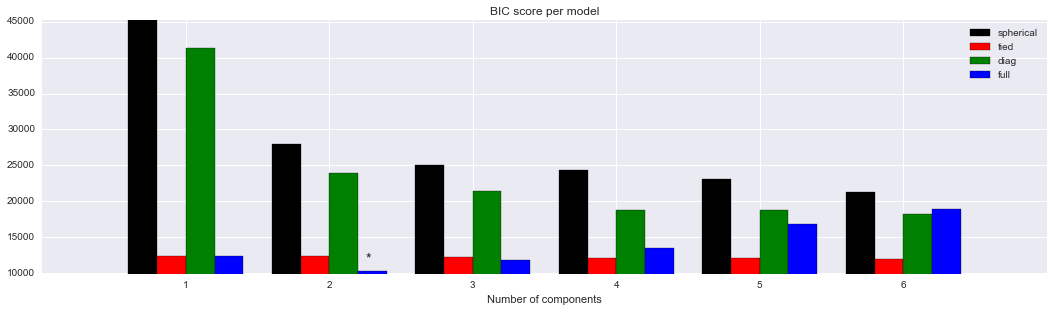

In [11]:
from sklearn import mixture 

X = prueba[selector].values.T
X1 = X
by_hour1 = by_hour
gmm = best_GMM(X)

num_clusters = 6
cv_types = ['spherical', 'tied', 'diag', 'full']
color_iter = ['blue', 'red', 'green', '#e017e5', '#d8f604', '#15d4e2', '#e21569']

gmm.fit(X)

La interpretación de los gráficos mostrados con el índice BIC, el cluster que recibió el menor índice en este caso es utilizando 2 clusters con una tendencia de covarianza full, es decir enteramente deformable y flexible.

# Coordenadas de las estaciones

In [12]:
CDMX_COORDINATES = (19.4186, -99.1686) 

#create empty map zoomed in on Mexico City
station_attrs = pd.read_csv('C:\Users\ghost\Google Drive\JairCastruitaGastelum\Progress Reports\Clustering_ECOBICI\DATA\estacion_coordenadas.csv')

Un ejemplo de como esta conformado el dataset con la ubicación de las estaciones:

In [13]:
station_attrs.head()

id  longitud   latitud
0   1 -99.16848  19.43293
1   2 -99.17151  19.43159
2   3 -99.15875  19.43166
3   4 -99.17169  19.42849
4   5 -99.16945  19.42980

In [14]:
by_hour_in.columns = by_hour_in.columns.astype(str) + ' in'
by_hour_out.columns = by_hour_out.columns.astype(str) + ' out'
by_hour_concat = pd.concat([by_hour_in.loc['weekday'],by_hour_out.loc['weekday']],axis=1)
by_hour_concat = by_hour_concat[6:]

Al realizar el proceso de agrupación a cada cluster se le asigna un color y se posicionan las estaciones por sus coordenadas geográficas con el color respectivo de su cluster. Nótese como a pesar de que no se utilizó ninguna propiedad geográfica los puntos tienden a estar concentrados en regiones cercandas.

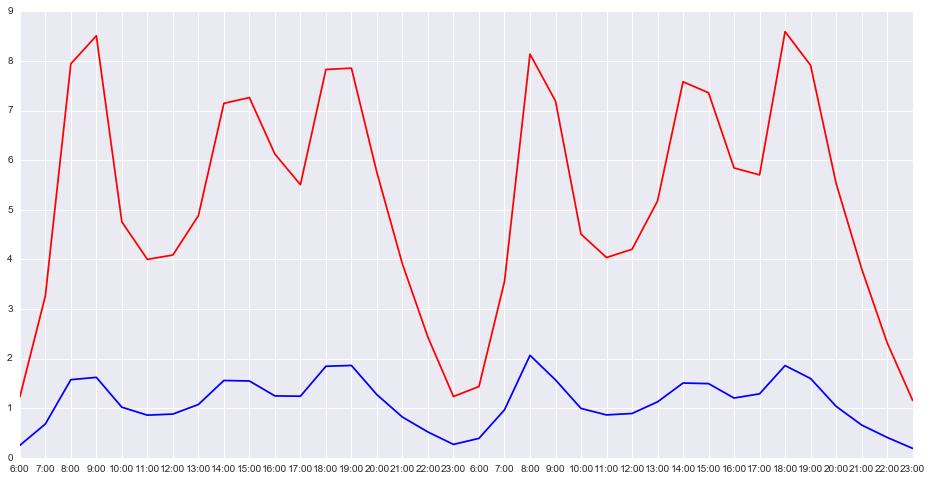

In [15]:
map = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)
Y_ = gmm.predict(X)
plt.figure(figsize=(16,8))

for i, (mean, covar, color) in enumerate(zip(
        gmm.means_, gmm._get_covars(), color_iter)):
        
    if not np.any(Y_ == i):
        continue  
        
    plt.xticks(range(len(np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))), 
               np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))        
    plt.plot(mean,color=color)
    
    for attr in range(len(Y_)):
        if Y_[attr] == i:
            alt = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['longitud'].values[0]
            lat = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['latitud'].values[0]
            
            counts = vincent.Bar(by_hour_concat[[str(by_hour.columns[attr])+' in',str(by_hour.columns[attr])+' out']], width=650, height=300)
            counts.axis_titles(x='Hora', y='Estacion '+str(int(by_hour.columns[attr]))+': Valor Promedio en un dia')
            counts.to_json(str(by_hour.columns[attr])+'.json')
            counts.legend(title=str(station_attrs.iloc[attr,0]))
                         
            folium.RegularPolygonMarker(location=[lat,alt], 
                                popup=folium.Popup(max_width=700).add_child(
                                                                folium.Vega(json.load(open(str(by_hour.columns[attr])+'.json')), 
                                                                width=700, 
                                                                height=350)),
                                fill_color=color,
                                number_of_sides=8,
                                radius=10).add_to(map)
    
map

La actividad en los gráficos de arriba describen los puntos que tomaron las coordenadas de cada centroide para cada cluster seleccionado.

### Fase 1

Es normal preguntarse si a lo largo de todo este periodo ocurrieron cambios realizados al sistema que pueden haber afectado de alguna manera la realización de este procedimiento de clustering. Debido a lo antes mencionado es un poco ingenuo el realizar un procedimiento de clusterización y análisis a los datos sin haber considerado la temporalidad del sistema, cuales estaciones fueron agregadas después de la iniciación de este proyecto y en que fechas comenzaron su funcionamiento. Es por eso que se ofrece a continuación este mismo proceso considerando el tiempo en el que comenzaron a funcionar las diferentes fases del sistema que fueron posteriormente agregadas. Lo siguiente que se propone realizar un enfoque más fragmentado en el tiempo, tomando en cuenta periodos y estaciones respectivos a la fase 1, 2 y 3.

Comenzando por la primer fase, que es desde el nacimiento del sistema, comprende un periodo desde el 2 de febredo del año 2010 hasta la inclusión de su segunda fase, en un periodo gradual que puede comprenderse desde primeros de octubre hasta finales de noviembre del año 2012 y solo tomando en cuenta aquellas estaciones que tuvieron actividad sobre este periodo de tiempo, las estaciones que comprenden a la fase 1 del programa.

In [16]:
station_phase_path = r'C:\Users\ghost\Google Drive\JairCastruitaGastelum\Progress Reports\Clustering_ECOBICI\DATA\ecobiciFases.csv'
station_phase = pd.read_csv(station_phase_path,header=None)
station_phase.columns = ['station','phase']

In [17]:
# count trips by date and by hour
by_hour_out = trips_out.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_removed').fillna(0).reset_index('hour')

by_hour_out = by_hour_out['2010-02-16':'2012-10-29']

# average these counts by weekend
by_hour_out['weekend'] = (by_hour_out.index.dayofweek >= 5)
by_hour_out = by_hour_out.groupby(['weekend', 'hour']).mean()
by_hour_out.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

by_hour_out.drop([col for col in list(by_hour_out.columns.values) if col not in station_phase[station_phase['phase'] <= 1]['station'].values or col >= 260], 
        axis=1, inplace=True)

In [18]:
# count trips by date and by hour
by_hour_in = trips_in.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_arrived').fillna(0).reset_index('hour')

by_hour_in = by_hour_in['2010-02-16':'2012-10-29']

# average these counts by weekend
by_hour_in['weekend'] = (by_hour_in.index.dayofweek >= 5)
by_hour_in = by_hour_in.groupby(['weekend', 'hour']).mean()
by_hour_in.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

by_hour_in.drop([col for col in list(by_hour_in.columns.values) if col not in station_phase[station_phase['phase'] <= 1]['station'].values or col >= 260], 
        axis=1, inplace=True)

In [19]:
by_hour = pd.concat([by_hour_in,by_hour_out],axis=0)

In [20]:
prueba = pd.DataFrame(data=by_hour.loc['weekday'].values,
                index=pd.to_datetime(by_hour.loc['weekday'].index, format='%H:%M').hour,
                columns=by_hour.loc['weekday'].columns)
selector=(prueba.index>=6)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

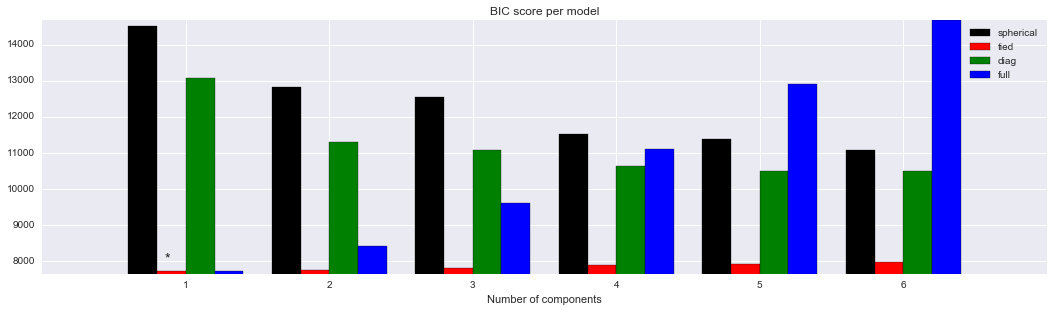

In [21]:
X = prueba[selector].values.T
X2 = X
by_hour2 = by_hour
gmm_2 = best_GMM(X)
gmm_2.fit(X)

El menor valor de clustering obtenido para este caso fue 1 cluster, con una covarianza full. 1 cluster muestra que no hay puntos importantes que separar en este caso.

In [22]:
by_hour_in.columns = by_hour_in.columns.astype(str) + ' in'
by_hour_out.columns = by_hour_out.columns.astype(str) + ' out'
by_hour_concat = pd.concat([by_hour_in.loc['weekday'],by_hour_out.loc['weekday']],axis=1)
by_hour_concat = by_hour_concat[6:]

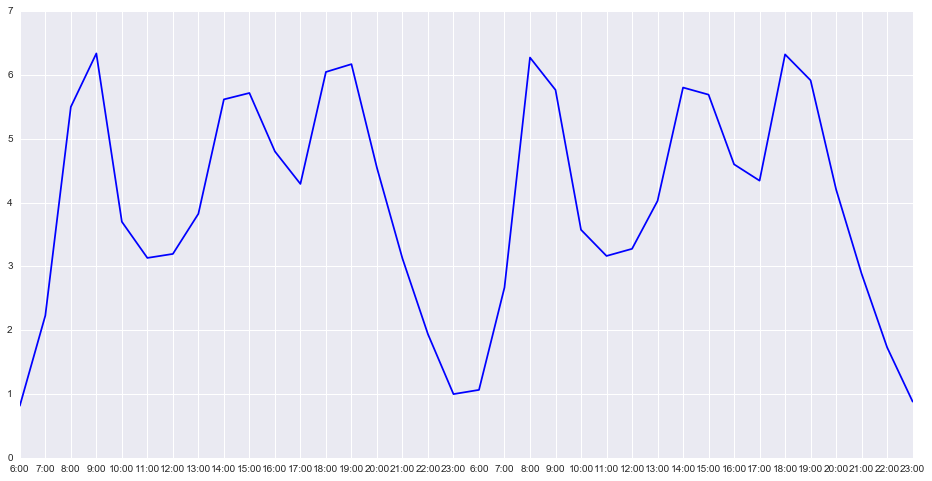

In [23]:
map2 = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)
Y_ = gmm_2.predict(X)
plt.figure(figsize=(16,8))

for i, (mean, covar, color) in enumerate(zip(
        gmm_2.means_, gmm_2._get_covars(), color_iter)):
        
    if not np.any(Y_ == i):
        continue   

    plt.xticks(range(len(np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))), 
               np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))
    plt.plot(mean,color=color)
    
    for attr in range(len(Y_)):
        if Y_[attr] == i:
            alt = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['longitud'].values[0]
            lat = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['latitud'].values[0]
            
            counts = vincent.Bar(by_hour_concat[[str(by_hour.columns[attr])+' in',str(by_hour.columns[attr])+' out']], width=650, height=300)
            counts.axis_titles(x='Hora', y='Estacion '+str(int(by_hour.columns[attr]))+': Valor Promedio en un dia')
            counts.to_json(str(by_hour.columns[attr])+'.json')
            counts.legend(title=str(station_attrs.iloc[attr,0]))
                         
            folium.RegularPolygonMarker(location=[lat,alt], 
                                popup=folium.Popup(max_width=700).add_child(
                                                                folium.Vega(json.load(open(str(by_hour.columns[attr])+'.json')), 
                                                                width=700, 
                                                                height=350)),
                                fill_color=color,
                                number_of_sides=8,
                                radius=10).add_to(map2)
    
map2

### Fase 2

Como se ha señalado anteriormente, no existe una separación temporal clara en los periodos cuando comenzó la fase 2 y la fase 3, pero podemos tomar como periodo comprendido los meses de octubre y noviembre para visualizar los cambios en el comportamiento de las estaciones durante la introducción de estas dos nuevas fases al sistema.

De nueva cuenta se realiza la selección de registros en el periodo de tiempo de interés:

In [24]:
# count trips by date and by hour
by_hour_out = trips_out.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_removed').fillna(0).reset_index('hour')

by_hour_out = by_hour_out['2012-10-29':'2012-11-29']

# average these counts by weekend
by_hour_out['weekend'] = (by_hour_out.index.dayofweek >= 5)
by_hour_out = by_hour_out.groupby(['weekend', 'hour']).mean()
by_hour_out.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in by_hour_out.loc[False].index]],
                         inplace=True);

by_hour_out.drop([col for col in list(by_hour_out.columns.values) if col not in station_phase[station_phase['phase'] <= 2]['station'].values or col >= 263], 
        axis=1, inplace=True)

In [25]:
# count trips by date and by hour
by_hour_in = trips_in.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_arrived').fillna(0).reset_index('hour')

by_hour_in = by_hour_in['2012-10-29':'2012-11-29']

# average these counts by weekend
by_hour_in['weekend'] = (by_hour_in.index.dayofweek >= 5)
by_hour_in = by_hour_in.groupby(['weekend', 'hour']).mean()
by_hour_in.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

by_hour_in.drop([col for col in list(by_hour_in.columns.values) if col not in station_phase[station_phase['phase'] <= 2]['station'].values or col >= 263], 
        axis=1, inplace=True)

In [26]:
by_hour = pd.concat([by_hour_in,by_hour_out],axis=0)

prueba = pd.DataFrame(data=by_hour.loc['weekday'].values,
                index=pd.to_datetime(by_hour.loc['weekday'].index, format='%H:%M').hour,
                columns=by_hour.loc['weekday'].columns)
selector=(prueba.index>=6)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

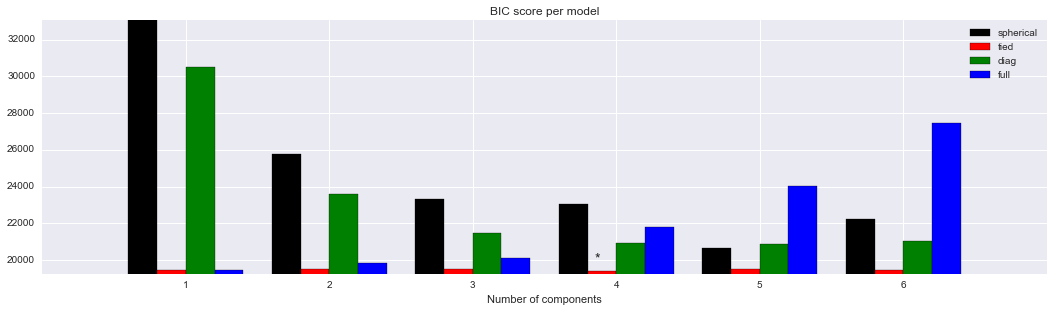

In [27]:
X = prueba[selector].values.T
X3 = X
by_hour3 = by_hour
gmm_3 = best_GMM(X)
gmm_3.fit(X)

In [28]:
by_hour_in.columns = by_hour_in.columns.astype(str) + ' in'
by_hour_out.columns = by_hour_out.columns.astype(str) + ' out'
by_hour_concat = pd.concat([by_hour_in.loc['weekday'][6:],by_hour_out.loc['weekday'][1:]],axis=1)

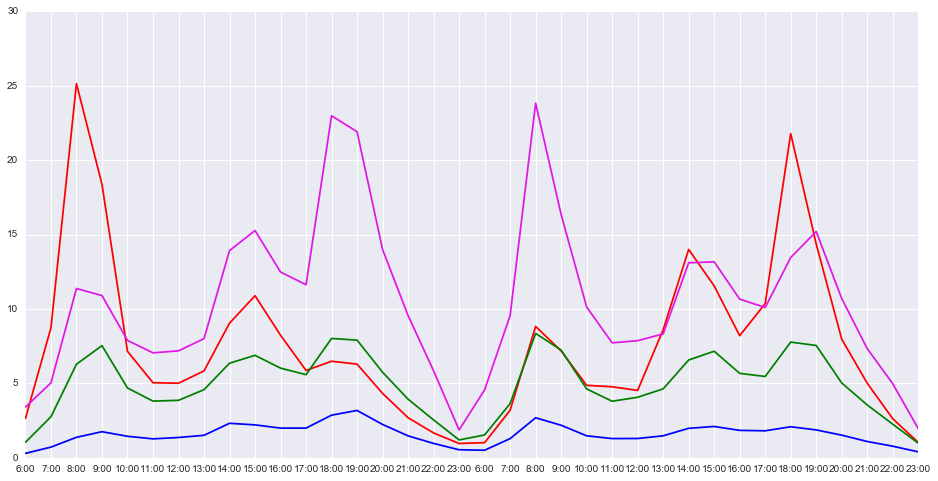

In [29]:
map3 = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)
Y_ = gmm_3.predict(X)
plt.figure(figsize=(16,8))

for i, (mean, covar, color) in enumerate(zip(
        gmm_3.means_, gmm_3._get_covars(), color_iter)):
        
    if not np.any(Y_ == i):
        continue 
        
    plt.xticks(range(len(np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))), 
               np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))        
    plt.plot(mean,color=color)
    
    for attr in range(len(Y_)):
        if Y_[attr] == i:
            alt = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['longitud'].values[0]
            lat = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['latitud'].values[0]
            
            counts = vincent.Bar(by_hour_concat[[str(by_hour.columns[attr])+' in',str(by_hour.columns[attr])+' out']], width=650, height=300)
            counts.axis_titles(x='Hora', y='Estacion '+str(int(by_hour.columns[attr]))+': Valor Promedio en un dia')
            counts.to_json(str(by_hour.columns[attr])+'.json')
            counts.legend(title=str(station_attrs.iloc[attr,0]))
                         
            folium.RegularPolygonMarker(location=[lat,alt], 
                                popup=folium.Popup(max_width=700).add_child(
                                                                folium.Vega(json.load(open(str(by_hour.columns[attr])+'.json')), 
                                                                width=700, 
                                                                height=350)),
                                fill_color=color,
                                number_of_sides=8,
                                radius=10).add_to(map3)
    
map3

El problema en los resultados obtenidos es que en medida que el experimento se repite, diferentes números de cluster pueden resultar con un mayor índice BIC. Es natural que en procesos de clustering donde la selección del centroide comienza en un punto aleatorio, como en este caso, pueda generarse discrepancia entre los elementos que conforman cada cluster, lo que realmente resulta un problema es que la evaluación del clustering no esté fija en cada corrida.

### Fase 3

Finalmente tomamos el periodo de tiempo perteneciente a la inclusión de la tercera fase. Ésta abarca desde finales de diciembre hasta el fin del tiempo comprendido en el conjunto de datos. Agrega una extensión en el servicio sobre las delegaciones de Polanco y Anzures y agregando nuevas estaciones sobre delegación La condesa y centro.

In [30]:
# count trips by date and by hour
by_hour_out = trips_out.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_removed').fillna(0).reset_index('hour')

by_hour_out = by_hour_out['2012-11-29':]

# average these counts by weekend
by_hour_out['weekend'] = (by_hour_out.index.dayofweek >= 5)
by_hour_out = by_hour_out.groupby(['weekend', 'hour']).mean()
by_hour_out.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in by_hour_out.loc[False].index]],
                         inplace=True);

by_hour_out.drop([col for col in list(by_hour_out.columns.values) if col not in station_phase[station_phase['phase'] <= 3]['station'].values], 
        axis=1, inplace=True)

In [31]:
# count trips by date and by hour
by_hour_in = trips_in.pivot_table('bike', aggfunc='count',
                            index=['date', 'hour'],
                            columns='station_arrived').fillna(0).reset_index('hour')

by_hour_in = by_hour_in['2012-11-29':]

# average these counts by weekend
by_hour_in['weekend'] = (by_hour_in.index.dayofweek >= 5)
by_hour_in = by_hour_in.groupby(['weekend', 'hour']).mean()
by_hour_in.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);

by_hour_in.drop([col for col in list(by_hour_in.columns.values) if col not in station_phase[station_phase['phase'] <= 3]['station'].values], 
        axis=1, inplace=True)

In [32]:
by_hour = pd.concat([by_hour_in,by_hour_out],axis=0)

prueba = pd.DataFrame(data=by_hour.loc['weekday'].values,
                index=pd.to_datetime(by_hour.loc['weekday'].index, format='%H:%M').hour,
                columns=by_hour.loc['weekday'].columns)
selector=(prueba.index>=6)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

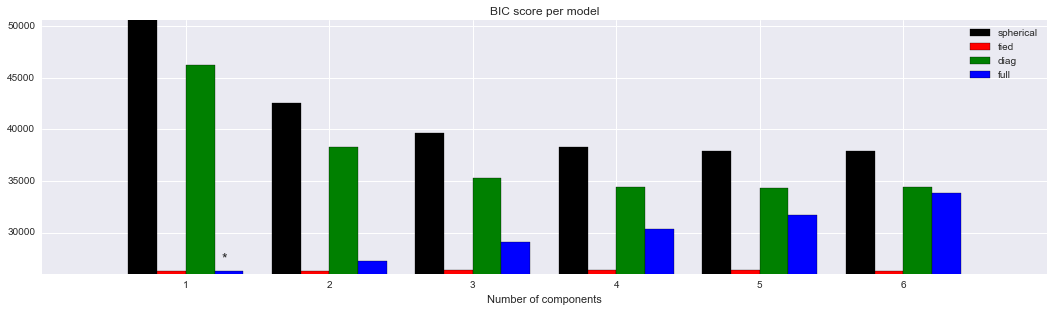

In [33]:
X = prueba[selector].values.T
X4 = X
by_hour4 = by_hour
gmm_4 = best_GMM(X)
gmm_4.fit(X)

In [34]:
by_hour_in.columns = by_hour_in.columns.astype(str) + ' in'
by_hour_out.columns = by_hour_out.columns.astype(str) + ' out'
by_hour_concat = pd.concat([by_hour_in.loc['weekday'][6:],by_hour_out.loc['weekday'][2:]],axis=1)

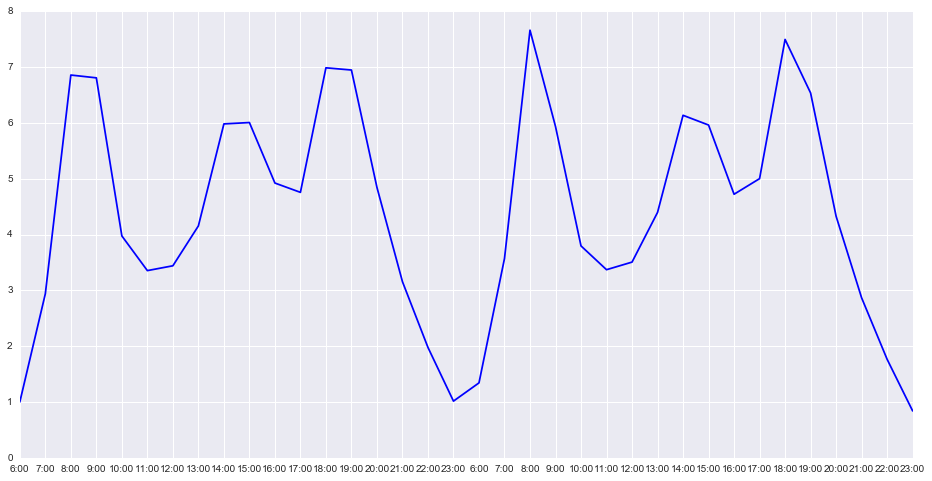

In [35]:
map4 = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)
Y_ = gmm_4.predict(X)
plt.figure(figsize=(16,8))

for i, (mean, covar, color) in enumerate(zip(
        gmm_4.means_, gmm_4._get_covars(), color_iter)):
        
    if not np.any(Y_ == i):
        continue
        
    plt.xticks(range(len(np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))), 
               np.concatenate([by_hour_concat.index.values,by_hour_concat.index.values]))    
    plt.plot(mean,color=color)
    
    for attr in range(len(Y_)):
        if Y_[attr] == i:
            alt = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['longitud'].values[0]
            lat = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['latitud'].values[0]
            
            counts = vincent.Bar(by_hour_concat[[str(by_hour.columns[attr])+' in',str(by_hour.columns[attr])+' out']], width=650, height=300)
            counts.axis_titles(x='Hora', y='Estacion '+str(int(by_hour.columns[attr]))+': Valor Promedio en un dia')
            counts.to_json(str(by_hour.columns[attr])+'.json')
            counts.legend(title=str(station_attrs.iloc[attr,0]))
                         
            folium.RegularPolygonMarker(location=[lat,alt], 
                                popup=folium.Popup(max_width=700).add_child(
                                                                folium.Vega(json.load(open(str(by_hour.columns[attr])+'.json')), 
                                                                width=700, 
                                                                height=350)),
                                fill_color=color,
                                number_of_sides=8,
                                radius=10).add_to(map4)
    
map4

De nueva cuena se seleccionó una agrupación con un solo cluster para la fase 3 la cual no sirve de nada para explicar los fenómenos.

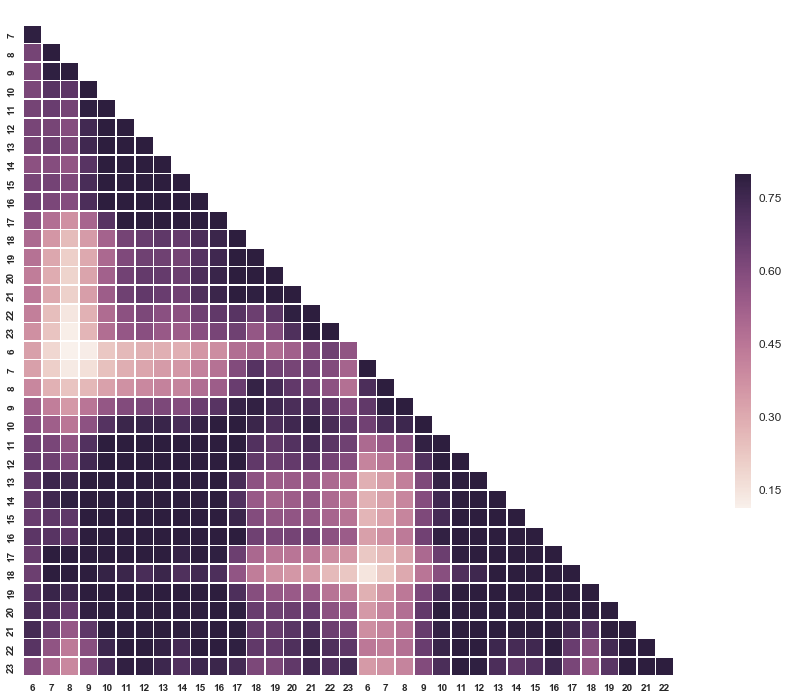

In [36]:
# Draw the heatmap using seaborn

sns.set(style="white")
# Compute the correlation matrix
corr = prueba[selector].T.corr()
aux_reverse = corr.columns[::-1].tolist()[:-1]
aux_reverse.append('')
aux = corr.columns.tolist()[:-1]
aux.append('')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
sns.set(font_scale=1.2)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, vmax=.8,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

ax.set(xticklabels=aux)
ax.set(yticklabels=aux_reverse)
for label in zip(ax.get_yticklabels(),ax.get_xticklabels()):
    label[0].set_weight("bold")
    label[1].set_weight("bold")

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [38]:
scaler = StandardScaler().fit(prueba[selector].T)
df_scaled = scaler.transform(prueba[selector].T)

print(df_scaled[:,0].mean())  # zero (or very close)
print(df_scaled[:,0].std())  # 1 (or very close)

-1.6027279754e-16
1.0


In [59]:
pca = PCA(n_components=0.95)  # consider enough components to explain 80% of the variance
pca.fit(df_scaled)
pcscores = pd.DataFrame(pca.transform(df_scaled))
pcscores.columns = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
loadings = pd.DataFrame(pca.components_, columns=prueba[selector].T.columns)
loadings.index = ['PC'+str(i+1) for i in range(len(pcscores.columns))]

Principal Component Analysis es una técnica de reducción de dimensionalidad en donde aquellas características que tengan un nivel de correlación elevado son descartados para quedarse con el menor número de características que expliquen la mayor variabilidad del fenómeno. Este tipo de técnicas existen debido a un fenómeno que se conoce como "la maldición de la dimensionalidad" o curse of dimensionality, en el que los modelos empeoran su rendimiento entre mayor número de características se utilicen.

Lo que PCA hace es contruir nuevas variables (o componentes principales) que explican la mayoría de la varianza o la dispersión del conjunto de datos original. Cada componente es una combinación lineal de todas las variables y es perpendicular de sus demás  componentes. Cada variable y cada componente es multiplicado por un conjunto de factores, los factores cargados (loading factors), que transforman el conjunto de datos original en este nuevo componente en el espacio. Estos factores cargados están restringidos para que el cuadrado de la suma sea igual a 1, y entonces puedan servir como pesos para ver cuáles parámetros son los más importantes para un componente principal.

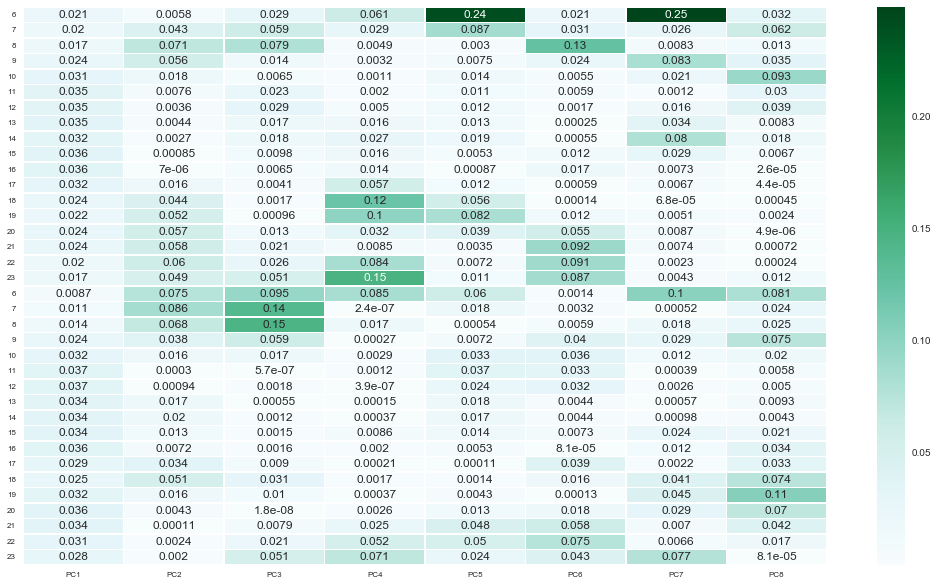

In [60]:
load_sqr = loadings**2
ax = sns.heatmap(load_sqr.transpose(), linewidths=0.5, cmap="BuGn", annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

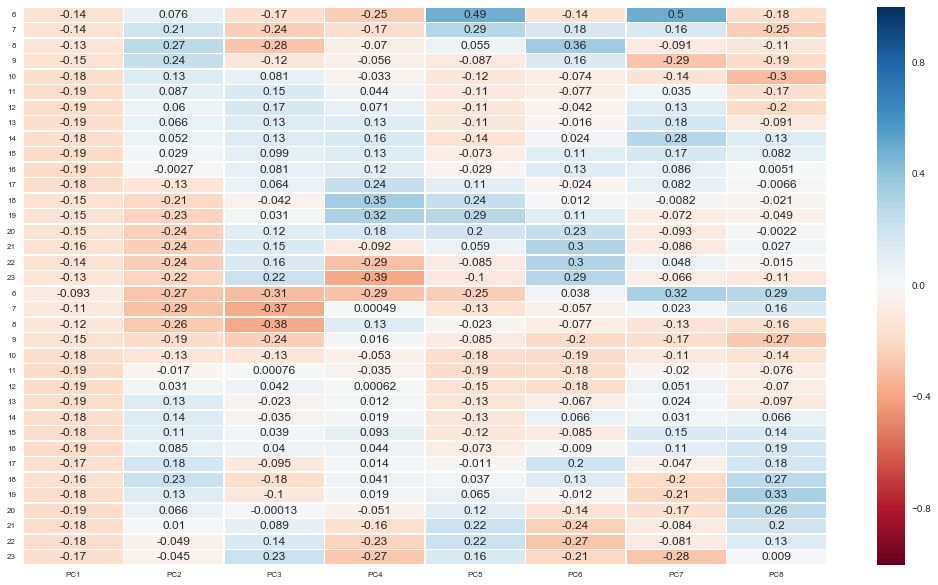

In [61]:
ax = sns.heatmap(loadings.transpose(), center=0, linewidths=0.5, 
                 cmap="RdBu", vmin=-1, vmax=1, annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

# Clustering ahora aplicando PCA:

La meta típica para PCA es la de reducir la dimensionalidad del espacio original de características proyectando en él un sub espacio menor, donde los eigenvectores formaran los ejes. Los eigenvecores solo definen las direcciones del nuevo eje, desde que todos ellos la misma longitud de 1.

In [42]:
def plot_PCA_var(eig_vals):
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    trace1 = Bar(
            x=['PC %s' %i for i in range(1,5)],
            y=var_exp,
            showlegend=False)

    trace2 = Scatter(
            x=['PC %s' %i for i in range(1,5)], 
            y=cum_var_exp,
            name='cumulative explained variance')

    data = Data([trace1, trace2])

    layout=Layout(
            yaxis=YAxis(title='Explained variance in percent'),
            title='Explained variance by different principal components')

    fig = Figure(data=data, layout=layout)
    return fig

In [43]:
def plot_PCA(gmm_PCA,X,by_hour):
    color_iter = ['blue', 'red', 'green', '#e017e5', '#d8f604', '#15d4e2', '#e21569']
    map = folium.Map(location=CDMX_COORDINATES, tiles='Stamen Toner', zoom_start=14)
    Y_ = gmm_PCA.predict(X)
    plt.figure(figsize=(16,8))
    
    for i, (mean, covar, color) in enumerate(zip(
            gmm_PCA.means_, gmm_PCA._get_covars(), color_iter)):

        if not np.any(Y_ == i):
            continue   
        
        plt.plot(mean,color=color)
        
        for attr in range(len(Y_)):
            if Y_[attr] == i:
                alt = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['longitud'].values[0]
                lat = station_attrs[station_attrs['id'] == by_hour.columns[attr]]['latitud'].values[0]
                folium.RegularPolygonMarker(location=[lat,alt],  
                                    fill_color=color,
                                    number_of_sides=8,
                                    radius=10).add_to(map)

    return map

In [44]:
def get_PCA(X):
    cov_mat = np.corrcoef(X)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    for ev in eig_vecs:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    print('Everything ok!')
    
    return eig_vals, eig_vecs

In [45]:
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [46]:
eig_vals, eig_vecs = get_PCA(X1.T)
fig = plot_PCA_var(eig_vals)

Everything ok!


La idea empleada aquí es quedarnos con los elementos de los eigenvectores que contengan los mayores eigenvalores y que estos expliquen la mayor cantidad de la variabilidad del fenómeno posibles:

En order de decidir qué eigenvectores pueden ser eliminados sin perder mucha información en la contrucción de un sub espacio dimensional menor, es necesario inspeccionar los eigenvalores correspondientes: los eigenvectores con los eigenvalores más pequeños que aportan la menor información acerca de la distribución de los datos; esos son los que pueden ser eliminados.
En orden de realizar lo anterior, la aproximación más común es el ordenar los eigenvalores del más grande al más pequeño y elegir los $k$ eigenvectores de mayor tamaño.

Después de ordenar los eigenpares, la siguiente pregunta es ¿cuántos componentes principales escoger para el nuevo sub espacio? Una medida útil es la llamada "varianza explicada", que puede ser calculada de los eigenvalores. La varianza explicada nos dice que tanta información (varianza) puede ser atribuida a cada componente principal.

En la figura de abajo las barras azules representan la varianza que explica el eigenvalor con mayor valor, seguido del segundo eigenvalor con mayor tamaño; la línea naranja representa la varianza explicada acumulativa.

In [47]:
py.iplot(fig)

Con lo que se mira en el gráfico anterior, solo las 4 primeras características con este criterio explican más del 94% de la variabilidad, un precio que muy bien puede pagarse para reducir 36 variables a solo 4. 

En este último paso utilizaremos la matriz de dimensión de 36 x 4 $W$ para transformar nuestras muestras en un sub espacio  con la ecuación $Y = X x W$, donde $Y$ es una matriz de 90 x 4 para nuestras estaciones de muestra transformadas

In [48]:
sklearn_pca = sklearnPCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X1)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=5, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

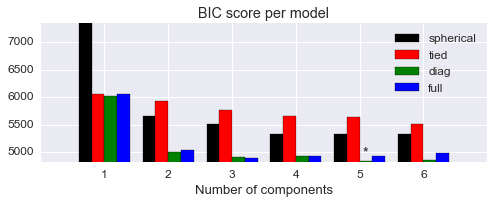

In [49]:
gmm_PCA = best_GMM(Y_sklearn)
gmm_PCA.fit(Y_sklearn)

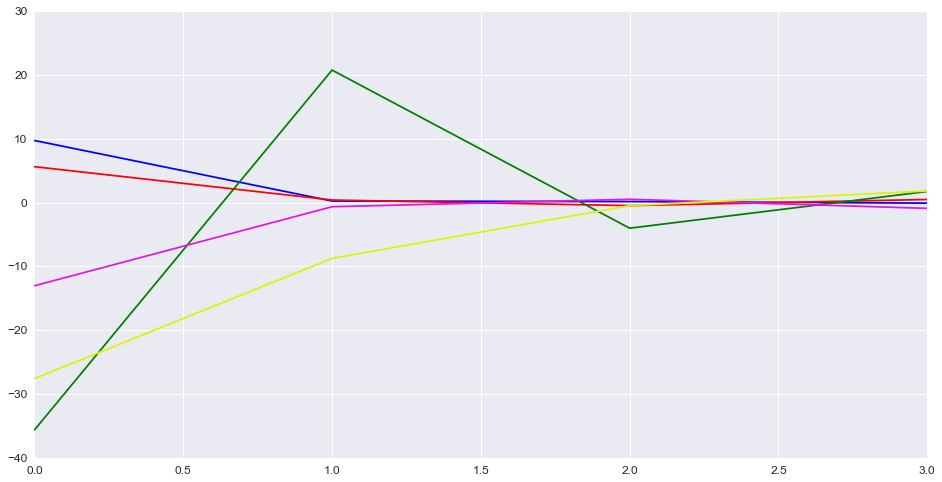

In [50]:
map_PCA = plot_PCA(gmm_PCA,Y_sklearn,by_hour1)

In [51]:
map_PCA

Después aplicada la reducción hay una mejora en el comportamiento del índice BIC que mayor información obtiene. Se vuelve más estable.

# Fase 1

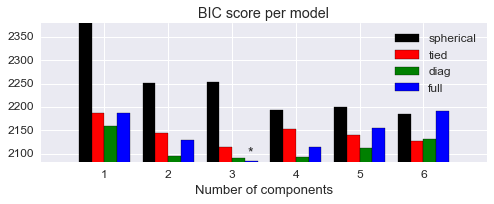

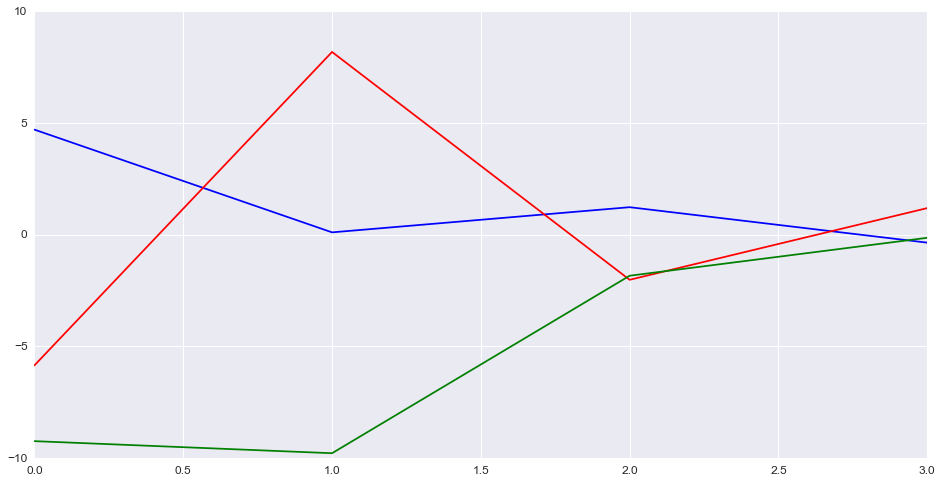

In [52]:
sklearn_pca2 = sklearnPCA(n_components=4)
Y_sklearn2 = sklearn_pca2.fit_transform(X2)

gmm_PCA2 = best_GMM(Y_sklearn2)
gmm_PCA2.fit(Y_sklearn2)

map_PCA2 = plot_PCA(gmm_PCA2,Y_sklearn2,by_hour2)

map_PCA2

# Phase 2

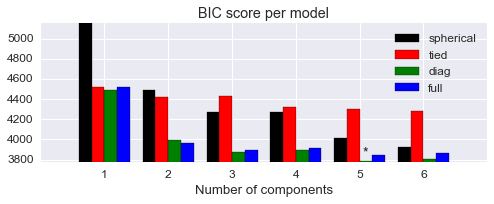

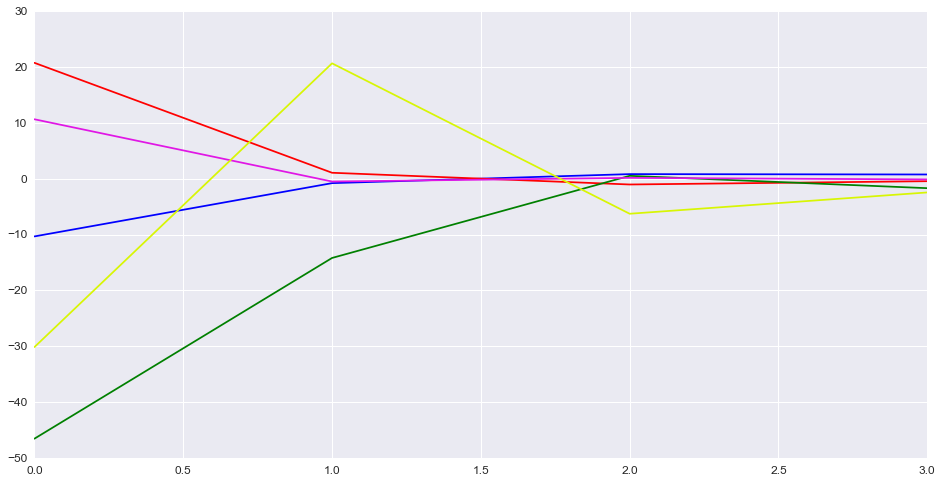

In [53]:
sklearn_pca3 = sklearnPCA(n_components=4)
Y_sklearn3 = sklearn_pca3.fit_transform(X3)

gmm_PCA3 = best_GMM(Y_sklearn3)
gmm_PCA3.fit(Y_sklearn3)

map_PCA3 = plot_PCA(gmm_PCA3,Y_sklearn3,by_hour3)

map_PCA3

# Phase 3

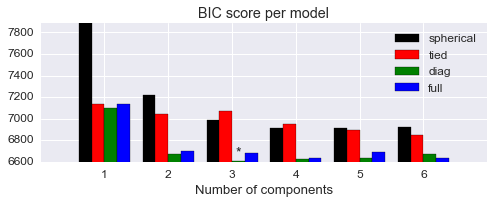

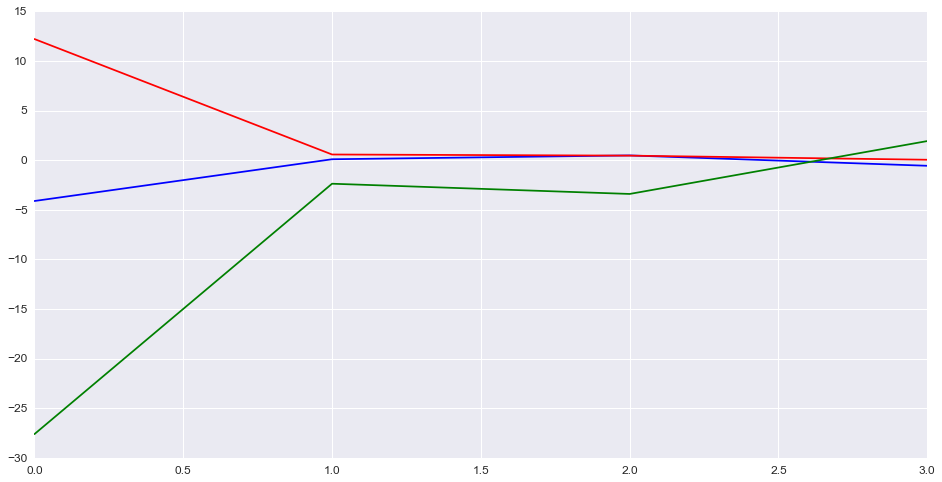

In [54]:
sklearn_pca4 = sklearnPCA(n_components=4)
Y_sklearn4 = sklearn_pca4.fit_transform(X4)

gmm_PCA4 = best_GMM(Y_sklearn4)
gmm_PCA4.fit(Y_sklearn4)

map_PCA4 = plot_PCA(gmm_PCA4,Y_sklearn4,by_hour4)

map_PCA4

La reducción en las características vuelve a la selección en número de clusters más estable. Después de ver agrupaciones separando periodos correspondientes a las fases donde entran nuevas estaciones en el sistema puede apreciarse que a lo largo del tiempo algunas estaciones se mantuvieron dentro del mismo cluster solo quizá con mayor actividad debido al mayor número de interacciones que se dan con cada apertura de una estación nueva. De cualquier forma, este tipo de visualización puede dar pie para solución en problemas que emergen de este sistema, como la saturación en de bicicletas en las estaciones.

In [3]:
from IPython.display import HTML
#To hide code from the nbviewer render
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')